# One_month_prediction_Alkalis

## TO-DOs
```
[v] Import monthly electrcity data
[v] Import monthly TTF_GAS data
[v] Import price evaluatioin data
[v] Create rows and encoding Alkalis_RM02_0001, Alkalis_RM02_0002
[v] To calculate the monthly average prices of Alkalis
[v] Create 12*N features, external factor prices from one-month before to 12-month before
[v] Combine features with target variables
[v] train_test_split() - do calculation and scaling only based on train data set to prevent data leakage
[x] Detect outliers - skip
[v] Check data distribution
[v] Data scaling - log transformation
[] check multicollinearity(to run one regression using each features, and find corr of all feature, filtering those with higher performance and least corr for our last model)
[v] Lasso regression - fit and transform train data set
[] Cross validation and Hyperparameter tuning using RandomizedSearchCV
[] Lasso regression - transform test data set
```

In [1]:
!pip install fredapi
!pip install pandasql

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def monthly_mean_to_daily(df_monthly: pd.core.frame.DataFrame ) -> pd.core.frame.DataFrame:
    """
    Convert Monthly data into Daily data and impute with monthly mean prices
    """
    df_monthly['Date'] = pd.to_datetime(df_monthly[['Year', 'Month']].assign(DAY=1))
    df = df_monthly.explode('Date') # The explode() method converts each element of the specified column(s) into a row.

    # Generate a complete range of daily dates for the year for imputation
    start_date = df['Date'].min() # represents the starting point of your data
    end_date = df['Date'].max() + pd.offsets.MonthEnd(1)  # finds the maximum (or latest) date and include the last month fully
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='D') # generates a fixed-frequency DatetimeIndex

    # Merge the full date range with the monthly averages to fill in all days
    df_full_date_range = pd.DataFrame(full_date_range, columns=['Date'])
    df = pd.merge(df_full_date_range, df_monthly, on='Date', how='left')
    df_daily = df.ffill(axis=0) # to fill the missing value based on last valid observation following index sequence
    return df_daily

In [4]:
## Import monthly electrcity data
elec_df = pd.read_csv('ELECTRICITY.csv').iloc[:,1:]
elec_df['Time'] = pd.to_datetime(elec_df['Year'].astype(str) + elec_df['Month'].astype(str), format='%Y%m')
elec_df = elec_df[elec_df['Year'].between(2011,2023)].reset_index().drop('index',axis=1)

print(elec_df.info())
print(elec_df.groupby(['Year']).count())
print(elec_df.isna().sum().sort_values()) # checking missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Year         156 non-null    int64         
 1   Month        156 non-null    int64         
 2   Electricity  156 non-null    float64       
 3   Time         156 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 5.0 KB
None
      Month  Electricity  Time
Year                          
2011     12           12    12
2012     12           12    12
2013     12           12    12
2014     12           12    12
2015     12           12    12
2016     12           12    12
2017     12           12    12
2018     12           12    12
2019     12           12    12
2020     12           12    12
2021     12           12    12
2022     12           12    12
2023     12           12    12
Year           0
Month          0
Electricity    0
Time        

In [5]:
## Import monthly TTF_GAS data
apiKey = '29219060bc68b2802af8584e0f328b52'
fred = Fred(api_key=apiKey)

# Get Natural Gas prices in Europe per month
TTF_gas_df = pd.DataFrame(fred.get_series('PNGASEUUSDM'), 
                       columns=['PNGASEUUSDM']).reset_index() 
TTF_gas_df['index'] = pd.to_datetime(TTF_gas_df['index'], format='%Y-%m-%d')
TTF_gas_df['Year'] = TTF_gas_df['index'].dt.year
TTF_gas_df['Month'] = TTF_gas_df['index'].dt.month
TTF_gas_df = TTF_gas_df[TTF_gas_df['Year'].between(2011,2023)]
TTF_gas_df.rename(columns = {'index':'Time'}, inplace = True)

print(TTF_gas_df.info())
print(TTF_gas_df.groupby(['Year']).count())
print(TTF_gas_df.isna().sum().sort_values()) # Check missing values




<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 312 to 467
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         156 non-null    datetime64[ns]
 1   PNGASEUUSDM  156 non-null    float64       
 2   Year         156 non-null    int64         
 3   Month        156 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 6.1 KB
None
      Time  PNGASEUUSDM  Month
Year                          
2011    12           12     12
2012    12           12     12
2013    12           12     12
2014    12           12     12
2015    12           12     12
2016    12           12     12
2017    12           12     12
2018    12           12     12
2019    12           12     12
2020    12           12     12
2021    12           12     12
2022    12           12     12
2023    12           12     12
Time           0
PNGASEUUSDM    0
Year           0
Month     

In [6]:
## Import price evaluatioin data
price_evo_df = pd.read_csv('Dataset_Predicting_Price_Evolutions.csv').iloc[:,1:]
price_evo_df['POSTING DATE'] = pd.to_datetime(price_evo_df['POSTING DATE'], format='%Y-%m-%d')
price_evo_df['Year'] = price_evo_df['POSTING DATE'].dt.year
price_evo_df['Month'] = price_evo_df['POSTING DATE'].dt.month
# price_evo_df = price_evo_df.sort_values(['Year','Month'],ascending=True)
price_evo_df = price_evo_df[price_evo_df['Year'].between(2012,2023)].reset_index().drop(['index'], axis=1)

price_evo_df.rename(columns = {'POSTING DATE':'Time'}, inplace = True)

# Drop unnecessary columns
price_evo_df = price_evo_df.drop(['SITE', 'SUPPLIER NUMBER', 'PURCHASE NUMBER', 'WEIGHT (kg)'], axis=1)

print(price_evo_df.info())
print(price_evo_df.groupby(['Year']).count())
print(price_evo_df.isna().sum().sort_values()) # Check missing values



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20570 entries, 0 to 20569
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Time               20570 non-null  datetime64[ns]
 1   Group Description  20570 non-null  object        
 2   Key RM code        20570 non-null  object        
 3   PRICE (EUR/kg)     20570 non-null  float64       
 4   Year               20570 non-null  int64         
 5   Month              20570 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 964.3+ KB
None
      Time  Group Description  Key RM code  PRICE (EUR/kg)  Month
Year                                                             
2012   604                604          604             604    604
2013   634                634          634             634    634
2014   803                803          803             803    803
2015   860                860     

In [7]:
## Create rows and encoding Alkalis_RM02_0001, 
## To calculate the monthly average prices of Alkalis
Alkalis_df = price_evo_df[price_evo_df['Group Description']=="Alkalis"].sort_values(['Year','Month'],ascending=True)
Alkalis_df = Alkalis_df.reset_index().drop('index',axis=1)

# encoding Alkalis_RM02_0001, Alkalis_RM02_0002 with n-1 dummy variables
Alkalis_df_dummies = pd.get_dummies(Alkalis_df['Key RM code'], drop_first=True)
# combine dummy variables with Alkalis_df
Alkalis_df_dummies = pd.concat([Alkalis_df, Alkalis_df_dummies], axis=1)
Alkalis_df_dummies = Alkalis_df_dummies.drop('Key RM code', axis=1)

## Calculate the average raw material price
"""
average_price = Alkalis_df_dummies.groupby(['Year','Month'])['PRICE (EUR/kg)']\
                                    .mean()\
                                    .reset_index()
Resetting the index of the resulting series is necessary to ensure that the indices align properly when merging the series back into the original dataframe.

When you perform a groupby operation in pandas, the resulting object is a new DataFrame or Series with a hierarchical index (MultiIndex) if you group by multiple columns. In your case, when you group by ['Year', 'Month'] and calculate the mean, the resulting Series has a MultiIndex consisting of 'Year' and 'Month'.

Merging this Series directly with the original dataframe without resetting the index could lead to issues because the indices won't align properly, and you may end up with NaN values or incorrect mappings.

Resetting the index of the resulting series converts the indices into regular integer indices, making it easier to merge with the original dataframe based on the common columns ('Year' and 'Month'). This ensures that the average prices are correctly aligned with the corresponding rows in the original dataframe.
"""
average_price = Alkalis_df_dummies.groupby(['Year','Month'])['PRICE (EUR/kg)']\
                                    .mean()\
                                    .reset_index()

# Merge the average monthly price with the original dataframe
Alkalis_df_dummies = pd.merge(Alkalis_df_dummies, average_price, on=['Year','Month'], suffixes=('', '_avg'))

# Rename the new column to 'Average_price'
Alkalis_df_dummies.rename(columns={'PRICE (EUR/kg)_avg': 'Average_price'}, inplace=True)
Alkalis_df_dummies = Alkalis_df_dummies.drop('PRICE (EUR/kg)', axis=1)

print(Alkalis_df_dummies.info())
print(Alkalis_df_dummies.sort_values('Time'))
print(Alkalis_df_dummies.isna().sum().sort_values())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6007 entries, 0 to 6006
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Time               6007 non-null   datetime64[ns]
 1   Group Description  6007 non-null   object        
 2   Year               6007 non-null   int64         
 3   Month              6007 non-null   int64         
 4   RM02/0002          6007 non-null   uint8         
 5   Average_price      6007 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1), uint8(1)
memory usage: 287.4+ KB
None
           Time Group Description  Year  Month  RM02/0002  Average_price
0    2012-01-31           Alkalis  2012      1          0       0.214250
1    2012-01-31           Alkalis  2012      1          0       0.214250
2    2012-01-31           Alkalis  2012      1          0       0.214250
3    2012-01-31           Alkalis  2012      1          0       

In [8]:
## Create 12*N features, external factor prices from one-month before to 12-month before
## Combine features with target variables
# To prepare feature datasets
merged_df = pd.merge(elec_df, TTF_gas_df,how='left', on = (['Year', 'Month', 'Time']))
feature_df = merged_df.copy()
feature_df['Time_label'] = feature_df['Time'].dt.strftime('%Y-%m')
feature_df = feature_df.drop(['Year','Month', 'Time'], axis=1) # to prevent duplicate columns when merging

# create time labels
label_dfs=[]    # To store labels
                # ref: 'https://pandas.pydata.org/docs/user_guide/merging.html'
    
for i in range(1,13): # 13 is not included
    label = Alkalis_df_dummies[['Time']]
    label.rename(columns = {'Time':f'Time_label{i}'}, inplace = True)
    label = (label[f'Time_label{i}'] - pd.DateOffset(months=i)).dt.strftime('%Y-%m')
    label_dfs.append(label)

result = pd.concat(label_dfs, axis=1)

# To merge with features
for i in range(1,13): # 13 is not included
    result = result.merge(feature_df, how='left',\
                          left_on=[f'Time_label{i}'],\
                          right_on=['Time_label'])
    result.rename(columns = {'Electricity':f'Electricity_{i}',
                              'PNGASEUUSDM':f'PNGASEUUSDM_{i}'
                             }, inplace = True)
    result = result.drop(['Time_label',f'Time_label{i}'], axis=1)
    
Alkalis_df_dummies = pd.concat([Alkalis_df_dummies,result],axis=1)
# print(Alkalis_df_dummies.info())
# print(Alkalis_df_dummies.head(20))
print((Alkalis_df_dummies.tail(1)))



           Time Group Description  ...  Electricity_12  PNGASEUUSDM_12
6006 2023-10-02           Alkalis  ...          501.92       20.806637

[1 rows x 30 columns]


In [18]:
## Calculate average prices based on Key RM Code
test = Alkalis_df_dummies.copy()
test = test.drop(['Time', 'Group Description', 'Year','Month'],axis=1)
print(test.groupby('RM02/0002')['Average_price'].mean())

RM02/0002
0    0.369994
1    0.339037
Name: Average_price, dtype: float64


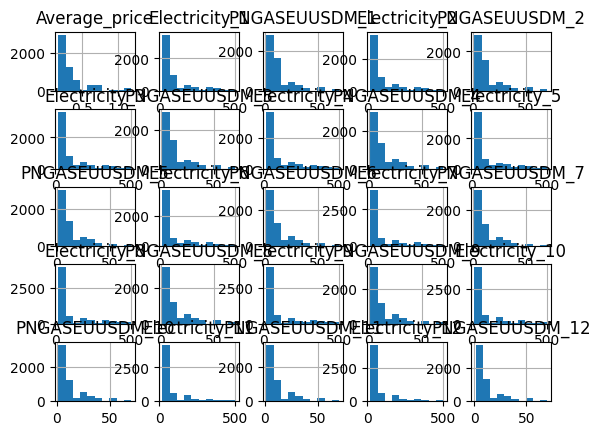

In [16]:
## train_test_split() - RM02/0001
## Log transformation

# Observe data distribution
Alkalis_df_dummies.drop(['RM02/0002','Time', 'Group Description', 'Year','Month'],axis=1).hist()
Alkalis_df_dummies['Average_price'].hist()

# Create X, y
feature_list = Alkalis_df_dummies.drop(['RM02/0002','Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = Alkalis_df_dummies['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y) # 30% of our data as the test set

# Log transformation - data is highly skewed
pow_trans_x = PowerTransformer()
pow_trans_x.fit(X_train)
X_train_log = pow_trans_x.transform(X_train)
X_test_log = pow_trans_x.transform(X_test)

pow_trans_y = PowerTransformer()
pow_trans_y.fit(y_train.reshape(-1, 1))  # Reshape y_train before fitting
y_train_log = pow_trans_y.transform(y_train.reshape(-1, 1))  # Reshape y_train during transformation
y_test_log = pow_trans_y.transform(y_test.reshape(-1, 1))  # Reshape y_test during transformation


In [13]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   # param_grid defines the grid of hyperparameters to search over.
                                   param_distributions=param_grid, 
                                   # n_iter determines the number samples
                                   n_iter=300, 
                                   # cv parameter sets the number of folds for cross-validation.
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_log, y_train_log)

# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])


# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)

print("Coefficients of the selected features in the best Lasso model:")
# zip(X, Y) is a Python built-in function that combines elements from two or more iterables (in this case, lists) into tuples.
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")

Best alpha parameter: 1e-07
Best R-squared score: 0.827
Coefficients of the selected features in the best Lasso model:
Electricity_1: 0.427
PNGASEUUSDM_1: -0.142
Electricity_2: 0.08
PNGASEUUSDM_2: 0.096
Electricity_3: -0.025
PNGASEUUSDM_3: -0.166
Electricity_4: 0.081
PNGASEUUSDM_4: 0.222
Electricity_5: 0.074
PNGASEUUSDM_5: -0.082
Electricity_6: 0.048
PNGASEUUSDM_6: 0.051
Electricity_7: 0.159
PNGASEUUSDM_7: 0.141
Electricity_8: 0.014
PNGASEUUSDM_8: 0.076
Electricity_9: -0.047
PNGASEUUSDM_9: -0.25
Electricity_10: 0.161
PNGASEUUSDM_10: 0.07
Electricity_11: 0.088
PNGASEUUSDM_11: 0.033
Electricity_12: -0.018
PNGASEUUSDM_12: -0.083


In [15]:
## Lasso regression - transform test data set
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_

# Fit the best Lasso model to the test data
best_lasso_model.fit(X_test_log, y_test_log)

# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_log)

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_log, y_test_log)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

Best Model: Lasso(alpha=1e-07)
Test Set R-squared score: 0.829
Lasso(alpha=1e-07)


\text{{Lasso}}: y = {\color{DarkRed} 0.427} \times \text{{Electricity\_1}} - 0.142 \times \text{{Gas\_1}} + 0.08 \times \text{{Electricity\_2}} + 0.096 \times \text{{Gas\_2}} - 0.025 \times \text{{Electricity\_3}} - 0.166 \times \text{{Gas\_3}} + 0.081 \times \text{{Electricity\_4}} + {\color{DarkRed} 0.222} \times \text{{Gas\_4}} + 0.074 \times \text{{Electricity\_5}} - 0.082 \times \text{{Gas\_5}} + 0.048 \times \text{{Electricity\_6}} + 0.051 \times \text{{Gas\_6}} + 0.159 \times \text{{Electricity\_7}} + 0.141 \times \text{{Gas\_7}} + 0.014 \times \text{{Electricity\_8}} + 0.076 \times \text{{Gas\_8}} - 0.047 \times \text{{Electricity\_9}} - {\color{DarkRed} 0.25} \times \text{{Gas\_9}} + 0.161 \times \text{{Electricity\_10}} + 0.07 \times \text{{Gas\_10}} + 0.088 \times \text{{Electricity\_11}} + 0.033 \times \text{{Gas\_11}} - 0.018 \times \text{{Electricity\_12}} - 0.083 \times \text{{Gas\_12}}
\\
\\Best \ alpha:\(1 \times 10^{-7}\)
\\Best \ R^{2}:\(0.827\)
\\
\\Test\ Set \ R^{2}: \(0.829\)

